## Name: Manohar Reddy Pulicharla

### Roll. No: 2022BCD0027

Installing Required Libraries

In [1]:
!pip install -q transformers datasets accelerate evaluate
!pip install -q kaggle
!pip install -q scikit-learn pandas numpy matplotlib seaborn

print("\n All libraries installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00

 All libraries installed successfully!


---

Importing Installed Libraries

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict, load_dataset
import torch

print(" All imports successful!")
print(f" Transformers version: {transformers.__version__}")
print(f" PyTorch version: {torch.__version__}")
print(f" Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

 All imports successful!
 Transformers version: 4.57.1
 PyTorch version: 2.8.0+cu126
 Device: cuda


---

Verifying Kaggle API Setup

In [3]:
from google.colab import files
import os

uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp "kaggle (1).json" ~/.kaggle/"kaggle.json"
!chmod 600 ~/.kaggle/kaggle.json

print("\n Kaggle API configured successfully!")

Saving kaggle (1).json to kaggle (1).json

 Kaggle API configured successfully!


---

Downloading Telugu News Dataset from Kaggle

In [4]:
print("\n Downloading Telugu EENADU News Articles dataset...")

!kaggle datasets download -d shubhamjain27/telugu-news-articles

!unzip -q telugu-news-articles.zip -d telugu_data

print("\n Dataset downloaded and extracted!")
print("\n Files in dataset:")
!ls -lh telugu_data/


Dataset URL: https://www.kaggle.com/datasets/shubhamjain27/telugu-news-articles
License(s): unknown
  0% 0.00/42.4M [00:00<?, ?B/s]
100% 42.4M/42.4M [00:00<00:00, 1.03GB/s]

 Dataset downloaded and extracted!

 Files in dataset:
total 47M
-rw-r--r-- 1 root root 9.3M Jul 11  2020 telugu_news_test.parquet
-rw-r--r-- 1 root root  38M Jul 11  2020 telugu_news_train.parquet


---

Loading Data and Exploring Dataset

In [5]:
train_df = pd.read_parquet('telugu_data/telugu_news_train.parquet')
test_df = pd.read_parquet('telugu_data/telugu_news_test.parquet')

print(f"\n Training samples: {len(train_df)}")
print(f" Test samples: {len(test_df)}")

print("\n Dataset columns:")
print(train_df.columns.tolist())

print("\n Class distribution (Training):")
print(train_df['category'].value_counts())

print("\n Sample training data:")
print(train_df.head(3))

print(f"\n Missing values in train: {train_df.isnull().sum().sum()}")
print(f" Missing values in test: {test_df.isnull().sum().sum()}")

train_df['text_length'] = train_df['text'].str.len()
print(f"\n📏 Text length statistics:")
print(f"   Mean: {train_df['text_length'].mean():.0f} characters")
print(f"   Median: {train_df['text_length'].median():.0f} characters")
print(f"   Max: {train_df['text_length'].max():.0f} characters")


 Training samples: 16421
 Test samples: 4106

 Dataset columns:
['title', 'text', 'category', 't']

 Class distribution (Training):
category
eenadu_sports      4539
eenadu_national    3687
eenadu_business    3267
eenadu_cinema      2520
eenadu_crime       2408
Name: count, dtype: int64

 Sample training data:
                                title  \
6214           పట్టుబిగించిన భారత్‌-ఎ   
19473  చైనాలో భూకంపాలు : 12 మంది మృతి   
13425           నేటి బోర్డు సమావేశాలు   

                                                    text         category  \
6214   \n                మైసూరు: దక్షిణాఫ్రికా-ఎతో రె...    eenadu_sports   
19473  \n                  125 మందికి గాయాలు\n\n\n\nబ...  eenadu_national   
13425  \n                * ఎన్‌టీపీసీ\n* ఆయిల్‌ ఇండియ...  eenadu_business   

                                                       t  
6214   పట్టుబిగించిన భారత్‌-ఎ \n                మైసూర...  
19473  చైనాలో భూకంపాలు : 12 మంది మృతి \n             ...  
13425  నేటి బోర్డు సమావేశాలు \n      

---

Visualizing Data Distribution in Dataset

Creating visualizations...


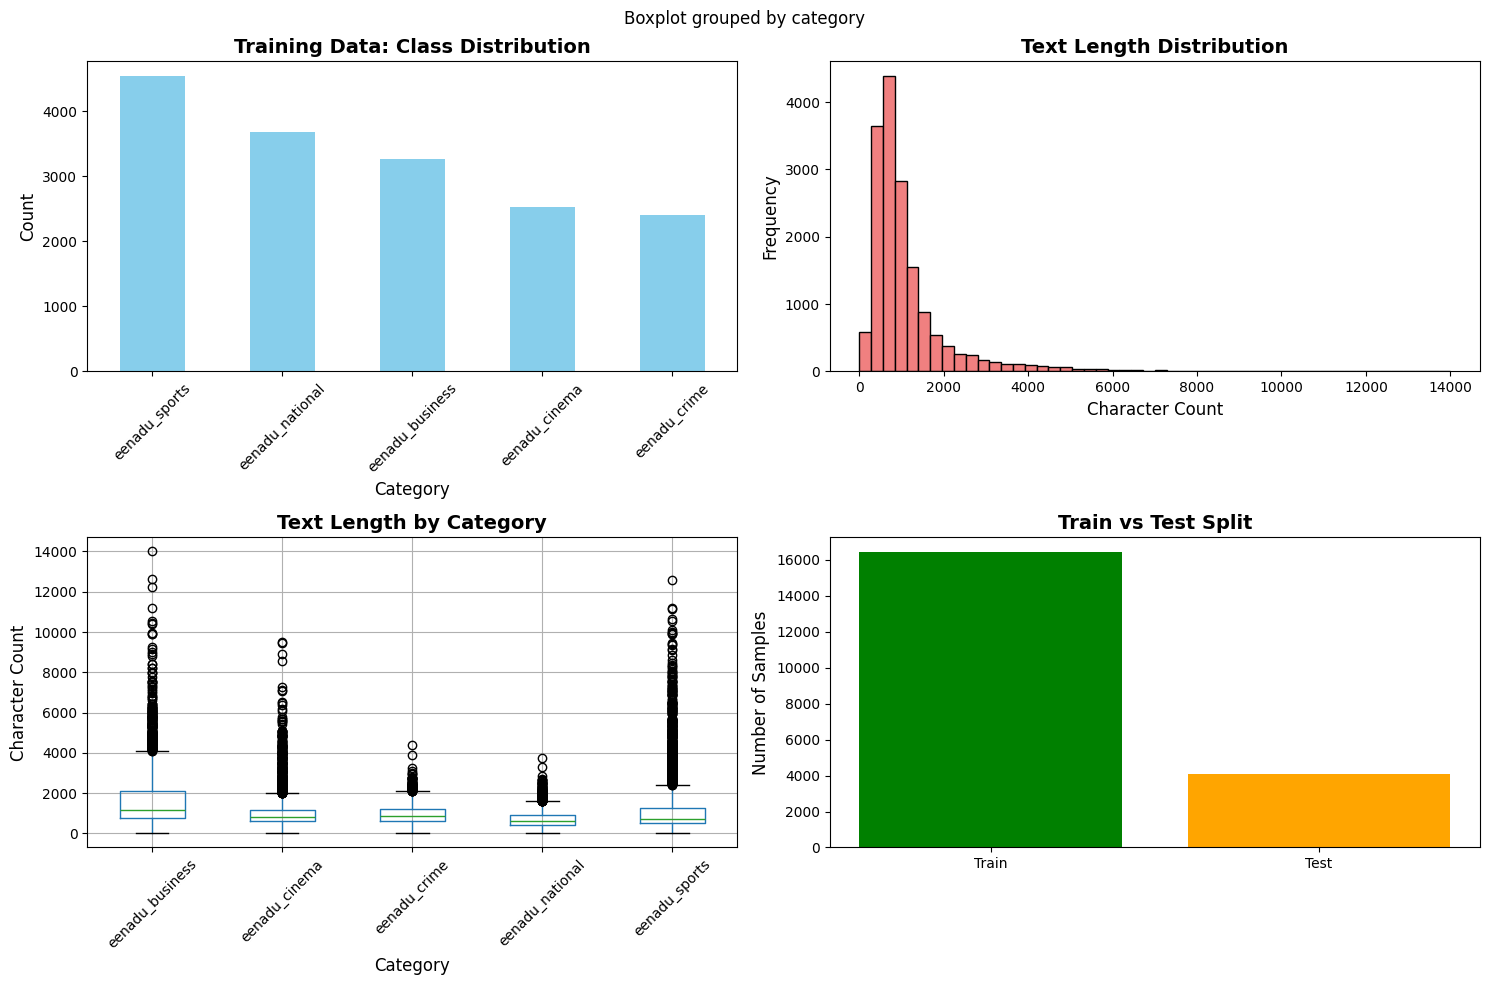

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Class distribution
train_df['category'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Training Data: Class Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Category', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Text length distribution
axes[0, 1].hist(train_df['text_length'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Character Count', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)

# 3. Box plot of text length by category
train_df.boxplot(column='text_length', by='category', ax=axes[1, 0])
axes[1, 0].set_title('Text Length by Category', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Category', fontsize=12)
axes[1, 0].set_ylabel('Character Count', fontsize=12)
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# 4. Dataset split comparison
split_data = pd.DataFrame({
    'Split': ['Train', 'Test'],
    'Count': [len(train_df), len(test_df)]
})
axes[1, 1].bar(split_data['Split'], split_data['Count'], color=['green', 'orange'])
axes[1, 1].set_title('Train vs Test Split', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Number of Samples', fontsize=12)

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

---

Preparing Data for Model to Train on

Converting pandas DataFrames to Hugging Face Dataset format

In [7]:
print("DATA PREPARATION")

if 'text_length' in train_df.columns:
    train_df = train_df.drop('text_length', axis=1)

print(f"\n Train columns: {train_df.columns.tolist()}")

if 'content' in train_df.columns:
    train_df = train_df.rename(columns={'content': 'text'})
if 'category' in train_df.columns:
    train_df = train_df.rename(columns={'category': 'label'})

if 'content' in test_df.columns:
    test_df = test_df.rename(columns={'content': 'text'})
if 'category' in test_df.columns:
    test_df = test_df.rename(columns={'category': 'label'})

label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}
num_labels = len(label_mapping)

print(f"\n Label mapping: {label_mapping}")
print(f" Number of classes: {num_labels}")

# Applying mapping
train_df['label'] = train_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print(f"\n Dataset Splitting Completed!")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")
print(f"\n Dataset structure:")
print(dataset)

with open('label_mapping.json', 'w', encoding='utf-8') as f:
    json.dump(label_mapping, f, ensure_ascii=False, indent=2)
print(f"\n Label mapping saved to 'label_mapping.json'")

DATA PREPARATION

 Train columns: ['title', 'text', 'category', 't']

 Label mapping: {'eenadu_sports': 0, 'eenadu_national': 1, 'eenadu_business': 2, 'eenadu_crime': 3, 'eenadu_cinema': 4}
 Number of classes: 5

 Dataset Splitting Completed!
   Training samples: 16421
   Test samples: 4106

 Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 16421
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 4106
    })
})

 Label mapping saved to 'label_mapping.json'


---

Loading BERT Model and Tokenizer for TELUGU Language.

In [8]:
model_name = "l3cube-pune/telugu-bert"
print(f"\n Loading model: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"\n Tokenizer loaded! Vocabulary size: {tokenizer.vocab_size}")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f" Model loaded successfully!")
print(f"   Model parameters: {model.num_parameters():,}")
print(f"   Device: {device}")
print(f"   Number of labels: {model.config.num_labels}")


 Loading model: l3cube-pune/telugu-bert


tokenizer_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]


 Tokenizer loaded! Vocabulary size: 197285


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/telugu-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded successfully!
   Model parameters: 237,560,069
   Device: cuda
   Number of labels: 5


---

Tokenizing Dataset

Converting Telugu text into tokens that BERT Model can understands

In [9]:
print("\n Tokenizing text data...")

def tokenize_function(examples):
    """Tokenizing text with padding and truncation"""
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512
    )

tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    desc="Tokenizing train dataset"
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    desc="Tokenizing test dataset"
)

tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("\n Tokenization complete!")
print(f"   Train samples: {len(tokenized_train)}")
print(f"   Test samples: {len(tokenized_test)}")


 Tokenizing text data...


Tokenizing train dataset:   0%|          | 0/16421 [00:00<?, ? examples/s]

Tokenizing test dataset:   0%|          | 0/4106 [00:00<?, ? examples/s]


 Tokenization complete!
   Train samples: 16421
   Test samples: 4106


---

Defining Evaluation Metrics

Creating function to compute accuracy, precision, recall, F1

In [10]:
def compute_metrics(eval_pred):
    """
    Computing accuracy, precision, recall, and F1 score
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average='weighted',
        zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print(" Evaluation metrics defined!")
print("\n Metrics that will be computed:")
print("   • Accuracy: Overall correctness")
print("   • Precision: Exactness of predictions")
print("   • Recall: Completeness of predictions")
print("   • F1-Score: Harmonic mean of precision and recall")

 Evaluation metrics defined!

 Metrics that will be computed:
   • Accuracy: Overall correctness
   • Precision: Exactness of predictions
   • Recall: Completeness of predictions
   • F1-Score: Harmonic mean of precision and recall


---

Configuring Training Arguments by Setting hyperparameters for training

In [11]:
training_args = TrainingArguments(
    output_dir='./telugu_text_classifier',
    logging_dir='./logs',
    logging_steps=50,

    # Evaluation strategy
    eval_strategy="epoch",  # Evaluating every time after each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    # Training hyperparameters
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,

    fp16=True,
    dataloader_num_workers=2,

    save_total_limit=2,

    seed=42,

    report_to="none",
)

print(" Training configuration complete!")
print(f"\n Key training parameters:")
print(f"   • Epochs: {training_args.num_train_epochs}")
print(f"   • Batch size (train): {training_args.per_device_train_batch_size}")
print(f"   • Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"   • Learning rate: {training_args.learning_rate}")

 Training configuration complete!

 Key training parameters:
   • Epochs: 3
   • Batch size (train): 16
   • Batch size (eval): 32
   • Learning rate: 2e-05


---

Initializing Trainer

Creating the Trainer object that will handle training

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print(" Trainer initialized successfully!")
print(f"\n Trainer configuration:")
print(f"   • Training samples: {len(tokenized_train)}")
print(f"   • Evaluation samples: {len(tokenized_test)}")
print(f"   • Model: {model_name}")
print(f"   • Device: {training_args.device}")

 Trainer initialized successfully!

 Trainer configuration:
   • Training samples: 16421
   • Evaluation samples: 4106
   • Model: l3cube-pune/telugu-bert
   • Device: cuda:0


---

Starting Actual Training

Train the model (THIS IS THE MAIN TRAINING CELL)

In [13]:
try:
    train_result = trainer.train()

    print("✅ TRAINING COMPLETED SUCCESSFULLY!")

except RuntimeError as e:
    if "out of memory" in str(e):
        print("❌ CPU OUT OF MEMORY ERROR")
    else:
        raise e

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.248600,0.234795,0.956892,0.957335,0.956892,0.956877
2,0.123800,0.147933,0.960058,0.960499,0.960058,0.960018
3,0.081500,0.145788,0.962737,0.962878,0.962737,0.962750


✅ TRAINING COMPLETED SUCCESSFULLY!


---

Evaluating on Test DataSet

final performance metrics on test dataset

In [15]:
print(" EVALUATING MODEL ON TEST SET")

eval_results = trainer.evaluate()

print("\n Evaluation complete!")
print(f"\n Test Set Performance:")
print(f"   • Accuracy:  {eval_results['eval_accuracy']*100:.2f}%")
print(f"   • Precision: {eval_results['eval_precision']*100:.2f}%")
print(f"   • Recall:    {eval_results['eval_recall']*100:.2f}%")
print(f"   • F1-Score:  {eval_results['eval_f1']*100:.2f}%")
print(f"   • Loss:      {eval_results['eval_loss']:.4f}")

with open('evaluation_results.json', 'w') as f:
    json.dump(eval_results, f, indent=2)
print("\n Results saved to 'evaluation_results.json'")

if eval_results['eval_accuracy'] > 0.85:
    print("\n Excellent performance! (Accuracy > 85%)")
elif eval_results['eval_accuracy'] > 0.75:
    print("\n Good performance! (Accuracy > 75%)")
else:
    print("\n Performance could be improved. Consider:")
    print("   • Training for more epochs")
    print("   • Adjusting learning rate")
    print("   • Using data augmentation")

 EVALUATING MODEL ON TEST SET



 Evaluation complete!

 Test Set Performance:
   • Accuracy:  96.27%
   • Precision: 96.29%
   • Recall:    96.27%
   • F1-Score:  96.27%
   • Loss:      0.1458

 Results saved to 'evaluation_results.json'

 Excellent performance! (Accuracy > 85%)


---

Generating Predictions and Confusion Matrix

Analyzing model predictions

 GENERATING PREDICTIONS



 Detailed Classification Report:
                 precision    recall  f1-score   support

  eenadu_sports       0.99      0.98      0.99      1154
eenadu_national       0.94      0.93      0.93       909
eenadu_business       0.95      0.98      0.96       791
   eenadu_crime       0.93      0.94      0.94       650
  eenadu_cinema       0.99      0.99      0.99       602

       accuracy                           0.96      4106
      macro avg       0.96      0.96      0.96      4106
   weighted avg       0.96      0.96      0.96      4106


 Generating confusion matrix...


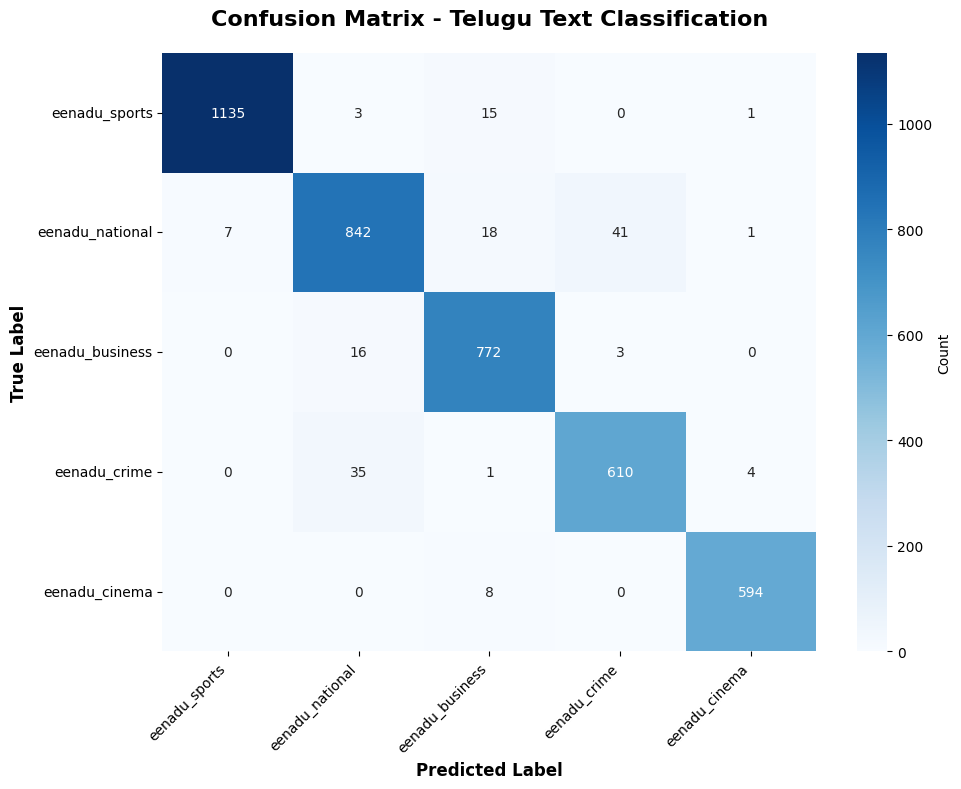


 Confusion matrix saved as 'confusion_matrix.png'


In [17]:
print(" GENERATING PREDICTIONS")

predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

reverse_label_mapping = {v: k for k, v in label_mapping.items()}

print("\n Detailed Classification Report:")
print("=" * 60)
target_names = [reverse_label_mapping[i] for i in range(num_labels)]
print(classification_report(true_labels, pred_labels, target_names=target_names))

print("\n Generating confusion matrix...")
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Telugu Text Classification', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Confusion matrix saved as 'confusion_matrix.png'")


---

Testing the model with custom Telugu text inputs

In [19]:
print(" TESTING MODEL WITH SAMPLE PREDICTIONS")

def predict_text(text, model, tokenizer, label_mapping):
    """
    Predict the category of a given Telugu text
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

    reverse_mapping = {v: k for k, v in label_mapping.items()}
    predicted_label = reverse_mapping[predicted_class]

    return predicted_label, confidence

print("\n Testing with sample texts from test set:\n")

sample_indices = np.random.choice(len(test_df), size=min(5, len(test_df)), replace=False)

for idx in sample_indices:
    text = test_df.iloc[idx]['text']
    true_label_id = test_df.iloc[idx]['label']
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    true_label = reverse_mapping[true_label_id]

    predicted_label, confidence = predict_text(text, model, tokenizer, label_mapping)

    display_text = text[:100] + "..." if len(text) > 100 else text

    print(f"\n Sample {idx + 1}:")
    print(f"   Text: {display_text}")
    print(f"   True Label: {true_label}")
    print(f"   Predicted: {predicted_label}")
    print(f"   Confidence: {confidence*100:.2f}%")
    print(f"   Status: {' Correct' if predicted_label == true_label else ' Incorrect'}")
    print("-" * 60)

print("\n Sample predictions completed!")

 TESTING MODEL WITH SAMPLE PREDICTIONS

 Testing with sample texts from test set:


 Sample 2127:
   Text: 
                

ఈనాడు డిజిటల్‌, హైదరాబాద్‌: తెలంగాణ తరపున జాతీయ, అంతర్జాతీయ క్రీడల్లో రాణిస్తున్న...
   True Label: eenadu_sports
   Predicted: eenadu_sports
   Confidence: 99.28%
   Status:  Correct
------------------------------------------------------------

 Sample 3658:
   Text: 
                బంగ్లాదేశ్‌తో భారత్‌ ప్రాక్టీస్‌ మ్యాచ్‌ నేడు
మధ్యాహ్నం 3 నుంచి స్టార్‌స్పోర్ట్స్‌ల...
   True Label: eenadu_sports
   Predicted: eenadu_sports
   Confidence: 99.28%
   Status:  Correct
------------------------------------------------------------

 Sample 3014:
   Text: 
                

దిల్లీ: క్యాబ్‌ సేవల సంస్థ ఉబర్‌ తమ ప్రయాణికులకు ఉచిత బీమా అందించనున్నట్లు ప్రకటి...
   True Label: eenadu_business
   Predicted: eenadu_business
   Confidence: 98.74%
   Status:  Correct
------------------------------------------------------------

 Sample 2123:
   Text: 
                  ఫోన్లో

---

Give your own input - My Model will classify it.

In [20]:
from IPython.display import display
import ipywidgets as widgets

def classify_telugu_text(input_text, model, tokenizer, label_mapping):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()
        confidence = probs.squeeze()[pred_class].item()
    reverse_map = {v: k for k, v in label_mapping.items()}
    pred_label = reverse_map[pred_class]
    return pred_label, confidence

input_box = widgets.Textarea(
    value='',
    placeholder='తెలుగు వార్తను ఇక్కడ ఇవ్వండి...',
    description='Telugu Text:',
    disabled=False,
    layout=widgets.Layout(width='70%', height='80px')
)

output_box = widgets.Output()

def on_button_click(b):
    output_box.clear_output()
    input_text = input_box.value.strip()
    if input_text == '':
        with output_box:
            print(" Please enter valid Telugu text.")
        return
    pred_label, confidence = classify_telugu_text(input_text, model, tokenizer, label_mapping)
    with output_box:
        print(f"\n Input Text: {input_text[:100]}{'...' if len(input_text) > 100 else ''}")
        print(f" Predicted Category: {pred_label}")
        print(f" Confidence: {confidence*100:.2f}%")

run_button = widgets.Button(description="Classify", button_style='info')
run_button.on_click(on_button_click)

display(input_box, run_button, output_box)
print("\nEnter any Telugu news/statement and click 'Classify' to see the predicted category!")


Textarea(value='', description='Telugu Text:', layout=Layout(height='80px', width='70%'), placeholder='తెలుగు …

Button(button_style='info', description='Classify', style=ButtonStyle())

Output()


Enter any Telugu news/statement and click 'Classify' to see the predicted category!


---